In [167]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive

In [168]:
# Mounting the drive

#drive.mount('/content/drive')

In [169]:
# Loading the data

#df = pd.read_csv('/content/drive/MyDrive/FDS Project Fall22/hate_crime.csv')
df = pd.read_csv('hate_crime.csv')
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


In [170]:
df.columns

Index(['INCIDENT_ID', 'DATA_YEAR', 'ORI', 'PUB_AGENCY_NAME', 'PUB_AGENCY_UNIT',
       'AGENCY_TYPE_NAME', 'STATE_ABBR', 'STATE_NAME', 'DIVISION_NAME',
       'REGION_NAME', 'POPULATION_GROUP_CODE', 'POPULATION_GROUP_DESC',
       'INCIDENT_DATE', 'ADULT_VICTIM_COUNT', 'JUVENILE_VICTIM_COUNT',
       'TOTAL_OFFENDER_COUNT', 'ADULT_OFFENDER_COUNT',
       'JUVENILE_OFFENDER_COUNT', 'OFFENDER_RACE', 'OFFENDER_ETHNICITY',
       'VICTIM_COUNT', 'OFFENSE_NAME', 'TOTAL_INDIVIDUAL_VICTIMS',
       'LOCATION_NAME', 'BIAS_DESC', 'VICTIM_TYPES', 'MULTIPLE_OFFENSE',
       'MULTIPLE_BIAS'],
      dtype='object')

In [171]:
# Taking the data until the year 2017

df = df[df['DATA_YEAR'] <= 2017]

In [172]:
# grouping by month-year for all incident dates

df['INCIDENT_DATE_STANDARD'] = pd.to_datetime(df['INCIDENT_DATE'])
df_train = df
df_train["MONTH_YEAR"] = df_train['INCIDENT_DATE_STANDARD'].dt.to_period('M')
df_grp = df_train.groupby(["MONTH_YEAR"])
date = []
total_crimes = []
for name, group in df_grp:
  date.append(str(name))
  total_crimes.append(group['INCIDENT_ID'].nunique())

df_count_date = pd.DataFrame()
df_count_date["Count"] = total_crimes

In [173]:
dataset = df_count_date.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = 310
test_size = 14
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=4):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

310 14


In [174]:
# Model training
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
305/305 - 2s - loss: 0.0086 - 2s/epoch - 6ms/step
Epoch 2/10
305/305 - 0s - loss: 0.0056 - 333ms/epoch - 1ms/step
Epoch 3/10
305/305 - 0s - loss: 0.0054 - 333ms/epoch - 1ms/step
Epoch 4/10
305/305 - 0s - loss: 0.0053 - 335ms/epoch - 1ms/step
Epoch 5/10
305/305 - 0s - loss: 0.0051 - 317ms/epoch - 1ms/step
Epoch 6/10
305/305 - 0s - loss: 0.0050 - 323ms/epoch - 1ms/step
Epoch 7/10
305/305 - 0s - loss: 0.0049 - 316ms/epoch - 1ms/step
Epoch 8/10
305/305 - 0s - loss: 0.0048 - 343ms/epoch - 1ms/step
Epoch 9/10
305/305 - 0s - loss: 0.0047 - 311ms/epoch - 1ms/step
Epoch 10/10
305/305 - 0s - loss: 0.0046 - 312ms/epoch - 1ms/step


In [175]:
# Model evaluation Part 1

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 14ms/step
Train Score: 112.51 RMSE
Test Score: 42.85 RMSE


In [176]:
testX

array([[[0.2811197 , 0.12150089, 0.15783204, 0.17569982]],

       [[0.12150089, 0.15783204, 0.17569982, 0.21560453]],

       [[0.15783204, 0.17569982, 0.21560453, 0.16974388]],

       [[0.17569982, 0.21560453, 0.16974388, 0.22275163]],

       [[0.21560453, 0.16974388, 0.22275163, 0.2185825 ]],

       [[0.16974388, 0.22275163, 0.2185825 , 0.19475879]],

       [[0.22275163, 0.2185825 , 0.19475879, 0.2340679 ]],

       [[0.2185825 , 0.19475879, 0.2340679 , 0.21441333]],

       [[0.19475879, 0.2340679 , 0.21441333, 0.21322216]]], dtype=float32)

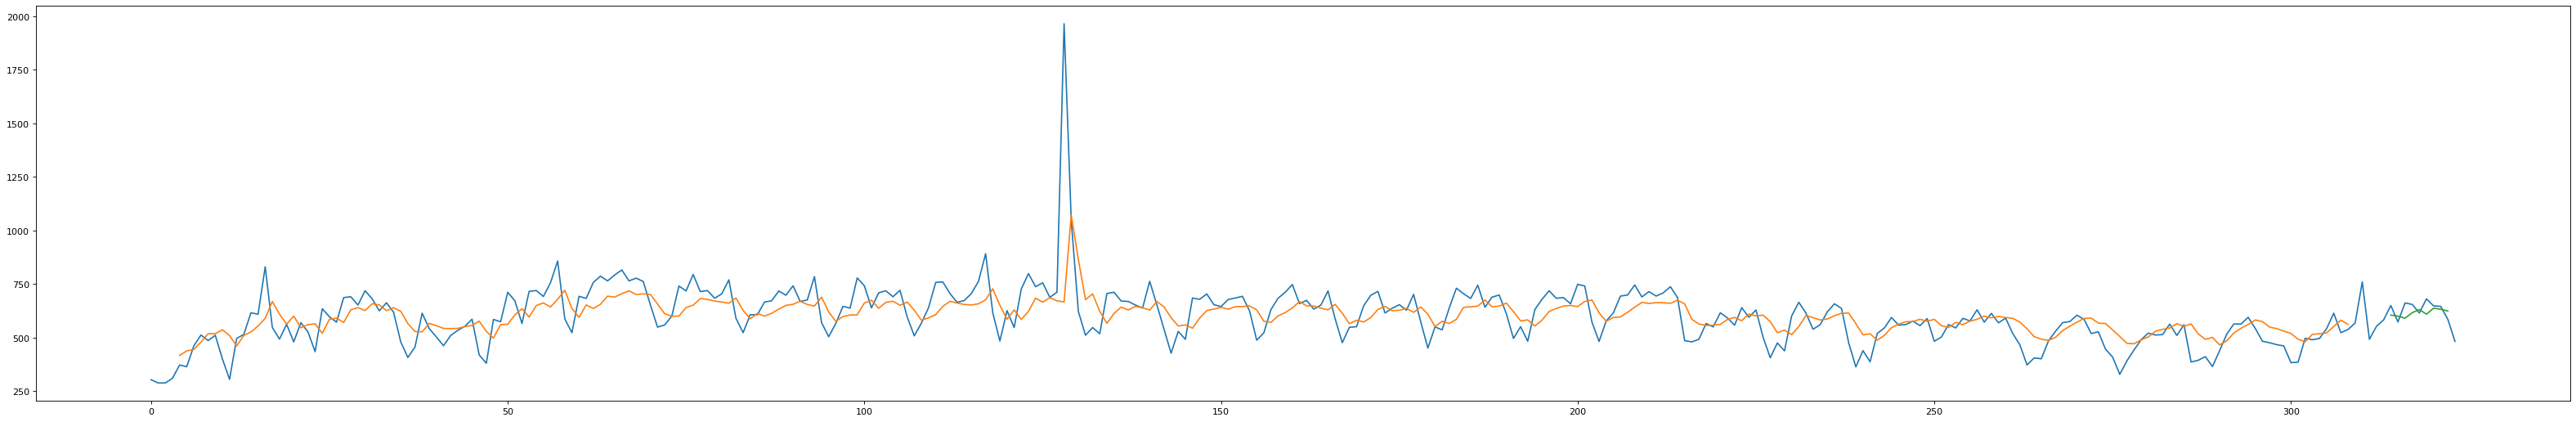

In [177]:
#plotting LSTM prediction on train as well as test inputs.

from matplotlib.pyplot import figure
figure(figsize=(50, 8), dpi=80)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


Text(0.5, 1.0, 'LSTM - 5.7%')

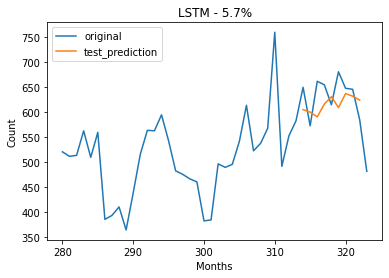

In [183]:
#Plotting for predicted and actual values and accuracy

test_prediction =[]
train_prediction =[]
for i in testPredictPlot.tolist():
  test_prediction.append(i[0])

for i in trainPredictPlot.tolist():
  train_prediction.append(i[0])

df_result = pd.DataFrame()
df_result["test_prediction"] = test_prediction
df_result["train_prediction"] = train_prediction
df_result["actual"] = scaler.inverse_transform(dataset)

plt.plot(df_result["actual"][280:],label="original")
plt.plot(df_result["test_prediction"],label="test_prediction")

plt.legend()
plt.xlabel("Months")
plt.ylabel("Count")
plt.title("LSTM - 5.7%")

In [179]:
df_result

,test_prediction,train_prediction,actual
0,NaN,NaN,302.0
1,NaN,NaN,287.0
2,NaN,NaN,287.0
3,NaN,NaN,309.0
4,NaN,415.927765,371.0
...,...,...,...
319,608.436890,NaN,680.0
320,636.469421,NaN,647.0
321,631.310120,NaN,645.0
322,623.384338,NaN,584.0


In [180]:
len(df)

194215

In [181]:
#Printing table with predicted values along with actual. The train prediction is NaN as we have divided the predicted values into train_prediction and test_prediction for ease of use
#Refer to the first plot for train prediction 
df_result_test = df_result[df_result["test_prediction"].notna()]
df_result_test = df_result_test.reset_index()
df_result_test

,index,test_prediction,train_prediction,actual
0,314,604.330933,NaN,649.0
1,315,599.343872,NaN,572.0
2,316,589.838623,NaN,661.0
3,317,615.413879,NaN,654.0
4,318,630.191528,NaN,614.0
5,319,608.436890,NaN,680.0
6,320,636.469421,NaN,647.0
7,321,631.310120,NaN,645.0
8,322,623.384338,NaN,584.0


In [185]:
#Printing the accuracy

# df_result
forecast_errors = [(np.abs(df_result_test["actual"][i] - df_result_test["test_prediction"][i]))/np.abs(df_result_test["actual"][i]) for i in range(len(df_result_test))]
mape = sum(forecast_errors)/len(forecast_errors)
print("MAPE Accuracy for LSTM :", mape*100)

MAPE Accuracy for LSTM : 5.775987115635084
